# Piecewise-Linear Regression

### `SMC` approach

In [1]:
# import libraries
import import_ipynb
import toolbox_sccf as sccf
import toolbox_SMC as smc

## basic imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
import seaborn as sns
import cvxpy as cp
clear_output()
np.random.seed(120824)

In [2]:
## problem dimensions

w = int(2)
B1 = int(5)
B2 = int(5)
N = int(1.5e3)
L = 100.0 # X search space dim

radius_data = 10 

## data representation
mode = 'full' # others include 'regular','truncated'
stand = False # others include False 

### synthetic data generation

In [3]:
from scipy.stats import ortho_group

def gt(omegas):
    return np.array([1/10*omega[-1]**3 + 1*np.sin(sum(omega)) + 4+omega[0]*omega[1]-2/10*np.sum(omega)**2 for omega in omegas]) 

In [4]:
'''
generate "num_points" random points in "dimension" that have uniform
 probability over the unit ball scaled by "radius" (length of points
 are in range [0, "radius"]).
'''

# https://stackoverflow.com/questions/54544971/how-to-generate-uniform-random-points-inside-d-dimension-ball-sphere 

def random_ball(num_points, dimension, radius=1):
    random_directions = np.random.normal(size=(dimension,num_points))
    random_directions /= np.linalg.norm(random_directions, axis=0)
    random_radii = np.random.random(num_points) ** (1/dimension)
    return radius * (random_directions * random_radii).T


omegas = random_ball(N,w,radius=radius_data)
taus = gt(omegas)

In [5]:
omega1 = np.linspace(-radius_data, radius_data, int(2e2))
omega2 = np.linspace(-radius_data, radius_data, int(2e2))

OMEGA1, OMEGA2 = np.meshgrid(omega1, omega2)   
list_omegas = []
for o1 in omega1:
    for o2 in omega2:
        list_omegas.append([o1,o2])

list_omegas = np.array(list_omegas)

### utils

In [6]:
'''
utils (global)
'''    

def extended_omegas(omegas,augmented=False):
    if augmented:
        N,d = omegas.shape
        embedding = np.zeros((N,int(d+d*(d+1)/2)))
        for s,samp in enumerate(omegas):
            new_omega = list(samp)
            buf = np.outer(samp,samp)
            for ofd in range(d):
                new_omega += list(np.diagonal(buf,ofd))
            embedding[s] = np.array(new_omega)
    else:
        embedding = omegas.copy()
    return np.hstack((embedding,np.ones((len(omegas),1))))

def rescale(data):
    num_samples,num_features = data.shape
    new_data = data.copy()
    means,stds = [],[]
    for colid,feat in enumerate(data.T):
        mfeat,stdfeat = np.mean(feat),np.std(feat)
        means.append(mfeat)
        stds.append(stdfeat)
        if stdfeat>0:
            new_data[:,colid] = (feat-mfeat)/stdfeat
    return new_data,means,stds

def coordinates(sigma_,B1_=B1,B2_=B2):
    assert sigma_>=0 and sigma_<=B1_*B2_-1, 'value range error (0 -> H-1)'
    e2 = sigma_%B2_
    e1 = (sigma_-(e2-1))/B2_
    return (int(e1),int(e2))

def selector(coordinates,B1_=B1,B2_=B2):
    return coordinates[1]+coordinates[0]*B2_

def recast(x,w_ext,B1_=B1,B2_=B2):
    assert len(x)==(B1_+B2_)*w_ext, 'dimension error'
    mat = x.reshape((B1_+B2_,w_ext))
    return mat[:B1_],mat[B1_:]

def mix(mat1,mat2):
    assert mat1.shape[1]==mat2.shape[1],'dimension error'
    buf = []
    for lm1 in mat1:
        for lm2 in mat2:
            buf.append(list(lm1+lm2))
    return np.array(buf)

def unfold(mat1,mat2):
    return (np.vstack((mat1,mat2))).flatten()

In [7]:
if mode=='regular':
    ext_omegas = extended_omegas(omegas)
    ext_list_omegas = extended_omegas(list_omegas)
else:
    ext_omegas_full = extended_omegas(omegas,True)
    ext_list_omegas_full = extended_omegas(list_omegas,True)
    if mode=='full':
        ext_omegas = ext_omegas_full.copy()
        ext_list_omegas = ext_list_omegas_full.copy()
    else:
        max_dim = ext_omegas_full.shape[1]-1
        select = np.concatenate((np.random.choice(np.arange(max_dim),replace=False,size=int(max_dim*2/3)),[max_dim]))
        ext_omegas = ext_omegas_full[:,select]
        ext_list_omegas = ext_list_omegas_full[:,select]

if stand:
    polished_omegas,means,stds = rescale(ext_omegas)
else:
    polished_omegas,means,stds = ext_omegas.copy(),np.zeros(len(ext_omegas)),np.zeros(len(ext_omegas))
    
polished_list_omegas = []
for idcol,col in enumerate(ext_list_omegas.T):
    if stds[idcol]>0:
        polished_list_omegas.append((col-means[idcol])/stds[idcol])
    else:
        polished_list_omegas.append(col)
polished_list_omegas = np.array(polished_list_omegas).T

        
w_ext = len(polished_omegas[0])

In [8]:
N_train = min(len(omegas),int(5e2))
id_train = np.random.choice(np.arange(len(omegas)),replace=False,size=N_train)

omegas_train = omegas[id_train]
polished_omegas_train = polished_omegas[id_train]
taus_train = taus[id_train]

In [9]:
from sklearn.cluster import KMeans
kmeans1 = KMeans(n_clusters=int(B1),n_init=20).fit(omegas_train)
kmeans2 = KMeans(n_clusters=int(B2),n_init=20).fit(omegas_train)

In [10]:
'''
functions
'''

def loss(x,target,data,B1_=B1,B2_=B2):
    mat1,mat2 = recast(x,data.shape[1],B1_,B2_)
    val1,val2 = mat1@data.T,mat2@data.T
    mval1,mval2 = np.max(val1,0),np.max(val2,0)
    preds = mval1-mval2
    return np.mean(np.abs(target-preds))

def h_vals(x,target,data,B1_=B1,B2_=B2):
    mat1,mat2 = recast(x,data.shape[1],B1_,B2_)
    val1,val2 = mat1@data.T,mat2@data.T
    mval1,mval2 = np.max(val1,0),np.max(val2,0)
    h_bar = np.maximum(target+mval2,mval1)+np.maximum(-target+mval1,mval2)
    mix_mat = mix(mat1,mat2)
    return np.outer(h_bar,np.ones(len(mix_mat)))-(mix_mat@data.T).T

In [11]:
"""
recovering of init affectation
"""
init_partition = []
for e1,e2 in zip(kmeans1.labels_,kmeans2.labels_):
    init_partition.append((e1,e2))

In [12]:
init_partition

[(2, 3),
 (0, 2),
 (1, 4),
 (3, 0),
 (4, 1),
 (1, 4),
 (0, 2),
 (3, 0),
 (3, 0),
 (4, 1),
 (0, 2),
 (4, 1),
 (3, 0),
 (0, 2),
 (1, 4),
 (2, 3),
 (4, 1),
 (0, 2),
 (1, 4),
 (1, 4),
 (1, 4),
 (3, 0),
 (1, 4),
 (3, 0),
 (1, 4),
 (0, 2),
 (1, 4),
 (0, 2),
 (4, 1),
 (2, 3),
 (3, 0),
 (3, 0),
 (1, 4),
 (2, 3),
 (3, 0),
 (0, 2),
 (4, 1),
 (3, 0),
 (4, 1),
 (4, 1),
 (4, 1),
 (4, 1),
 (0, 2),
 (1, 4),
 (3, 0),
 (2, 3),
 (3, 0),
 (4, 1),
 (4, 1),
 (0, 2),
 (0, 2),
 (2, 3),
 (1, 4),
 (0, 2),
 (3, 0),
 (0, 2),
 (0, 2),
 (3, 0),
 (3, 0),
 (0, 2),
 (4, 1),
 (1, 4),
 (4, 1),
 (0, 2),
 (1, 4),
 (4, 1),
 (4, 1),
 (1, 4),
 (0, 2),
 (3, 0),
 (3, 0),
 (2, 3),
 (3, 0),
 (4, 1),
 (2, 3),
 (0, 2),
 (4, 1),
 (1, 4),
 (4, 1),
 (3, 0),
 (1, 4),
 (3, 0),
 (2, 3),
 (4, 1),
 (4, 1),
 (1, 4),
 (0, 2),
 (3, 0),
 (2, 3),
 (1, 4),
 (3, 0),
 (0, 2),
 (4, 1),
 (4, 1),
 (1, 4),
 (3, 0),
 (3, 0),
 (3, 0),
 (2, 3),
 (3, 0),
 (2, 3),
 (2, 3),
 (1, 4),
 (3, 0),
 (2, 3),
 (4, 1),
 (4, 1),
 (4, 1),
 (4, 1),
 (0, 2),
 (0, 2),
 

In [13]:
def part2weights(partition,B1_=B1,B2_=B2):
    N_loc = len(partition)
    buf = np.zeros((N_loc,B1_*B2_))
    for idtup,tup in enumerate(partition):
        buf[idtup,selector(tup)] += 1
    return [buf]

### package instance

In [14]:
# param
margin = .0

# variables
mat1_cvx = cp.Variable((B1,w_ext))
mat2_cvx = cp.Variable((B2,w_ext))

# constraints
list_cstr_cvx = [cp.norm(mat1_cvx[e1][:-1],'inf')<=L for e1 in range(B1)] + [cp.norm(mat2_cvx[e2][:-1],'inf')<=L for e2 in range(B2)]

# prior-knowledge encoding (-> symmetry breaking)
if B1>1:
    for e1 in range(B1-1):
        list_cstr_cvx += [cp.sum(mat1_cvx[e1])+margin<=cp.sum(mat1_cvx[e1+1])]
if B2>1:
    for e2 in range(B2-1):
        list_cstr_cvx += [cp.sum(mat2_cvx[e2])+margin<=cp.sum(mat2_cvx[e2+1])]

# objective function implementation
data = polished_omegas_train.copy()
target = taus_train.copy()
N_t = len(data)

val1_cvx,val2_cvx = mat1_cvx@data.T,mat2_cvx@data.T
mval1_cvx,mval2_cvx = cp.max(val1_cvx,0),cp.max(val2_cvx,0)
h_bar_cvx = cp.maximum(target+mval2_cvx,mval1_cvx)+cp.maximum(-target+mval1_cvx,mval2_cvx)
main_term = 1/N_t * cp.sum(h_bar_cvx)
list_expr = []
for l in range(B1*B2):
    e1_sel,e2_sel = coordinates(l)
    list_expr.append(-1/N_t * data@(mat1_cvx[e1_sel]+mat2_cvx[e2_sel]))

objective_smc = smc.SumMinExpr(list_min_exprs=[smc.MinExpr(list_expr)],main_fun=main_term)

prob_smc = smc.Problem(objective_smc,list_cstr_cvx)

In [15]:
wsw = part2weights(init_partition)

In [16]:
prob_smc.solve(method='vandessel',min_decr=1e-4,maxIters=int(100),verb_=True,extra_verb_=False,warm_start_weights=wsw.copy(),tol=1e-9)

iter. 0001 | Fval. 8.9377e-01 | BICval. 9.7083e-01 | decr.  inf | temp. -1.0000e+00
iter. 0002 | Fval. 8.7966e-01 | BICval. 9.2322e-01 | decr. 4.7610e-02 | temp. -1.7067e+02
iter. 0003 | Fval. 8.5875e-01 | BICval. 8.9487e-01 | decr. 2.8354e-02 | temp. -2.2756e+02
iter. 0004 | Fval. 8.4825e-01 | BICval. 8.6604e-01 | decr. 2.8830e-02 | temp. -3.0341e+02
iter. 0005 | Fval. 8.4560e-01 | BICval. 8.5536e-01 | decr. 1.0673e-02 | temp. -4.0454e+02
iter. 0006 | Fval. 8.3950e-01 | BICval. 8.5080e-01 | decr. 4.5636e-03 | temp. -5.3939e+02
iter. 0007 | Fval. 8.3719e-01 | BICval. 8.5015e-01 | decr. 6.5211e-04 | temp. -3.5959e+02
iter. 0008 | Fval. 8.3413e-01 | BICval. 8.4274e-01 | decr. 7.4102e-03 | temp. -4.7946e+02
iter. 0009 | Fval. 8.3418e-01 | BICval. 8.3894e-01 | decr. 3.7937e-03 | temp. -6.3928e+02
iter. 0010 | Fval. 8.3412e-01 | BICval. 8.3741e-01 | decr. 1.5298e-03 | temp. -8.5237e+02
iter. 0011 | Fval. 8.3396e-01 | BICval. 8.3625e-01 | decr. 1.1604e-03 | temp. -1.1365e+03
iter. 0012 | Fva

{'iters': 19,
 'stopping_condition': 0.0,
 'objective_values': [0.8937712908609683,
  0.8796636731979106,
  0.8587486967617224,
  0.8482501213941305,
  0.8456042783625435,
  0.8394964542267189,
  0.8371863947584188,
  0.8341286575412141,
  0.8341772430023866,
  0.8341208652798286,
  0.8339640755066284,
  0.833964075510039,
  0.8339640845395024,
  0.8339633450016208,
  0.8339293465112405,
  0.8339050722943284,
  0.8339000348623813,
  0.8339000401692829,
  0.8339000401692829]}

In [17]:
prob_smc.solve(method='am',maxIters=int(100),verb_=True,extra_verb_=False,warm_start_weights=wsw.copy(),tol=1e-9)

iter. 0001 | Fval. 8.9377e-01 | BICval. 9.7083e-01 | divinf. 1.0000e+00
iter. 0002 | Fval. 8.7583e-01 | BICval. 8.7714e-01 | divinf. 1.0000e+00
iter. 0003 | Fval. 8.7246e-01 | BICval. 8.7246e-01 | divinf. 0.0000e+00
-> terminated (stopping condition satisfied)


{'iters': 3,
 'stopping_condition': 0.0,
 'objective_values': [0.8937712908609683,
  0.8758338657980858,
  0.8724582569323047]}

In [18]:
prob_smc.solve(method='boyd',maxIters=int(100),verb_=True,extra_verb_=False,warm_start_weights=wsw.copy(),tol=1e-9)

iter. 0001 | Fval. 8.9377e-01 | BICval. 9.7083e-01 | divinf. 1.0417e-01
iter. 0002 | Fval. 8.9199e-01 | BICval. 9.6270e-01 | divinf. 1.3889e-01
iter. 0003 | Fval. 8.9175e-01 | BICval. 9.5484e-01 | divinf. 1.2153e-01
iter. 0004 | Fval. 8.8214e-01 | BICval. 9.4631e-01 | divinf. 1.0417e-01
iter. 0005 | Fval. 8.8167e-01 | BICval. 9.3670e-01 | divinf. 1.0417e-01
iter. 0006 | Fval. 8.8158e-01 | BICval. 9.2700e-01 | divinf. 1.0417e-01
iter. 0007 | Fval. 8.7727e-01 | BICval. 9.1677e-01 | divinf. 1.0417e-01
iter. 0008 | Fval. 8.7391e-01 | BICval. 9.0530e-01 | divinf. 1.0417e-01
iter. 0009 | Fval. 8.7297e-01 | BICval. 8.9340e-01 | divinf. 1.0417e-01
iter. 0010 | Fval. 8.7288e-01 | BICval. 8.8135e-01 | divinf. 1.0417e-01
iter. 0011 | Fval. 8.7243e-01 | BICval. 8.7323e-01 | divinf. 1.0417e-01
iter. 0012 | Fval. 8.7101e-01 | BICval. 8.7224e-01 | divinf. 1.0417e-01
iter. 0013 | Fval. 8.7087e-01 | BICval. 8.7201e-01 | divinf. 1.0417e-01
iter. 0014 | Fval. 8.7086e-01 | BICval. 8.7188e-01 | divinf. 1.0

{'iters': 22,
 'stopping_condition': 0.0,
 'objective_values': [0.8937712908609683,
  0.8919913001845998,
  0.8917528486333595,
  0.8821364873588209,
  0.8816652799132498,
  0.8815819997009839,
  0.8772720158208358,
  0.8739053909300765,
  0.872968736759276,
  0.87288151199391,
  0.8724271201106149,
  0.8710100616701766,
  0.870869724157501,
  0.8708608374636242,
  0.8708577705017433,
  0.8707873776625092,
  0.8707873775786084,
  0.8707873775788357,
  0.8707873780683713,
  0.8707873776468205,
  0.8707873775792905,
  0.8707873776472752]}

In [19]:
loss(unfold(mat1_cvx.value,mat2_cvx.value),taus_train,polished_omegas_train)

0.8707873776472623

### cvx chunks

In [20]:
def PLR_solve(choices,target,data,B1_=B1,B2_=B2,L_=L,margin=0,verb_=False):
    
    # dims
    N,w_ext = data.shape
    
    # variables
    mat1_cvx = cp.Variable((B1_,w_ext))
    mat2_cvx = cp.Variable((B2_,w_ext))

    # constraints
    list_cstr_cvx = [cp.norm(mat1_cvx[e1][:-1],'inf')<=L_ for e1 in range(B1_)] + [cp.norm(mat2_cvx[e2][:-1],'inf')<=L_ for e2 in range(B2_)]
    
    # prior-knowledge encoding (-> symmetry breaking)
    if B1_>1:
        for e1 in range(B1_-1):
            list_cstr_cvx += [cp.sum(mat1_cvx[e1])+margin<=cp.sum(mat1_cvx[e1+1])]
    if B2_>1:
        for e2 in range(B2_-1):
            list_cstr_cvx += [cp.sum(mat2_cvx[e2])+margin<=cp.sum(mat2_cvx[e2+1])]
    
    # objective function implementation
    val1_cvx,val2_cvx = mat1_cvx@data.T,mat2_cvx@data.T
    mval1_cvx,mval2_cvx = cp.max(val1_cvx,0),cp.max(val2_cvx,0)
    h_bar_cvx = cp.maximum(target+mval2_cvx,mval1_cvx)+cp.maximum(-target+mval1_cvx,mval2_cvx)
    fun_obj_cvx = 1/N * cp.sum(h_bar_cvx)
    for s,sel_s in enumerate(choices):
        e1_sel,e2_sel = sel_s
        fun_obj_cvx -= 1/N * data[s]@(mat1_cvx[e1_sel]+mat2_cvx[e2_sel])
    
    # problem set-up
    prob_cvx = cp.Problem(cp.Minimize(fun_obj_cvx),list_cstr_cvx)
    
    ################# solving time <- 
    
    prob_cvx.solve(solver=cp.MOSEK,warm_start=True,verbose=verb_)
    
    ################# printing time <- 
    if verb_:
        print(' ')
        print('obj. fun. value: '+str(prob_cvx.value))
    
    return mat1_cvx.value,mat2_cvx.value

In [21]:
'''
MM-standardizing procedure applied for active piece selection

ARGUMENTS::

tol (float) in [0,1] -> percentage of (Max-Min) gap tolerated for selection


OUTPUTS::

@complete
'''
def active_span(list_of_vals,tol=5e-2):
    
    # parameter
    MIN_SLACK = 1e-2
    
    # assertion
    assert tol>=0 and tol<=1, 'tol should be a float in [0,1]'
    
    # main code
    selectable = []
    for raw_vals in list_of_vals:
        vals = np.array(raw_vals)
        min_val,max_val = min(vals),max(vals)
        selectable.append(list(np.where((vals-min_val)/max(MIN_SLACK,max_val-min_val)<=tol)[0]))
    
    return selectable

'''
others...
'''

import random
import itertools


def random_selection(list_of_indices,num=int(1)):
    
    # assertion 
    assert num>=1, 'num should be an integer'
    
    local_num = int(num)
    
    # main code
    if local_num==1:
        return [random.choice(indices) for indices in list_of_indices]
    else:
        buf = []
        for _ in range(local_num):
            buf.append([random.choice(indices) for indices in list_of_indices])
        return buf
    
def reachable_size(list_of_indices):
    return np.prod([len(indices) for indices in list_of_indices])
    
def possible_selections(list_of_indices,max_num=int(1e3)):
    counter = 0
    buf = []
    for elem in itertools.product(*list_of_indices):
        buf.append(elem)
        counter += 1
        if counter>=max_num:
            return buf
    return buf

In [22]:
mat1_init,mat2_init = PLR_solve(choices=init_partition,target=taus_train,data=polished_omegas_train,verb_=True)

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) May 25 12:10:54 PM: Your problem has 60 variables, 18 constraints, and 0 parameters.
(CVXPY) May 25 12:10:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 25 12:10:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 25 12:10:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 25 12:10:54 PM: Compiling problem (target solver=MOSEK).
(CVXPY) May 25 12:10:54 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

(CVXPY) May 25 12:10:55 PM: 22  6.8e-05  5.1e-05  3.7e-03  4.50e-01   1.019314621e+00   1.021820174e+00   4.9e-05  0.23  
(CVXPY) May 25 12:10:55 PM: 23  5.5e-05  4.1e-05  3.0e-03  3.39e-01   1.012795330e+00   1.014912862e+00   4.0e-05  0.24  
(CVXPY) May 25 12:10:55 PM: 24  4.0e-05  3.0e-05  2.2e-03  4.10e-01   1.003563320e+00   1.005227885e+00   2.9e-05  0.24  
(CVXPY) May 25 12:10:55 PM: 25  3.1e-05  2.4e-05  1.7e-03  4.98e-01   9.988506684e-01   1.000257097e+00   2.3e-05  0.25  
(CVXPY) May 25 12:10:55 PM: 26  2.2e-05  1.6e-05  1.2e-03  4.59e-01   9.916622140e-01   9.927011426e-01   1.6e-05  0.25  
(CVXPY) May 25 12:10:55 PM: 27  1.2e-05  9.4e-06  6.7e-04  7.05e-01   9.831233749e-01   9.837728922e-01   9.0e-06  0.26  
(CVXPY) May 25 12:10:55 PM: 28  8.7e-06  6.5e-06  4.7e-04  8.67e-01   9.796377910e-01   9.800902117e-01   6.3e-06  0.26  
(CVXPY) May 25 12:10:55 PM: 29  3.9e-06  2.9e-06  2.1e-04  9.19e-01   9.752099959e-01   9.754141933e-01   2.8e-06  0.27  
(CVXPY) May 25 12:10:55 

In [23]:
Niters = 10
max_investigation = int(1e2)
H = int(B1*B2)
sched = np.array(int(Niters)*[0])

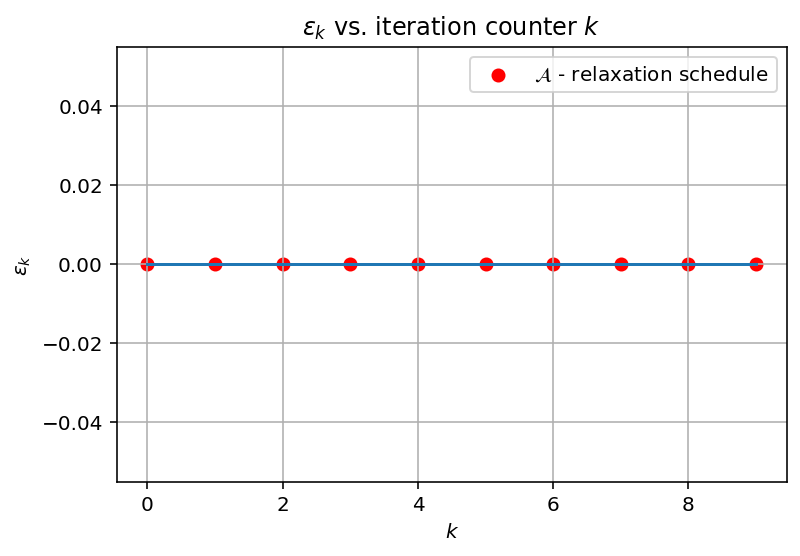

In [24]:
plt.grid()
plt.plot(np.arange(Niters),sched)
plt.scatter(np.arange(Niters),sched,color='red',label='$\\mathcal{A}$ - relaxation schedule')
plt.xlabel('$k$')
plt.ylabel('$\\epsilon_k$')
plt.legend()
#plt.yscale('log')
plt.title('$\\epsilon_k$ vs. iteration counter $k$');

In [25]:
x_ = unfold(mat1_init,mat2_init)

local_eval = lambda x: h_vals(x,taus_train,polished_omegas_train)
local_true_val = lambda x: loss(x,taus_train,polished_omegas_train)
sel_opt = [np.random.randint(0,H) for _ in range(N_train)]

TOL = 1e-4

for k in range(Niters):
    # ev. time
    list_vals = local_eval(x_)
    actives_ = active_span(list_vals,tol=sched[k])
    print('max num: '+str(reachable_size(actives_)))
    p_sel_ = possible_selections(actives_,max_num=max_investigation)
    ref = np.inf
    print('iter. '+str(k+1)+' with '+str(len(p_sel_))+' reachable nodes for eps = '+str(np.format_float_scientific(sched[k], unique=False, precision=3)))
    print(' ')
    prev_x_ = x_.copy()
    prev_sel_opt = sel_opt.copy()
    for id_sel,sel in enumerate(p_sel_):
        partition = [coordinates(sigma) for sigma in sel]
        mat1_,mat2_= PLR_solve(choices=partition,target=taus_train,data=polished_omegas_train,verb_=False)
        x_cand = unfold(mat1_,mat2_)
        new_loc_tv = local_true_val(x_cand)
        if new_loc_tv<ref:
            print('improvement -> '+str(new_loc_tv)+' with ID #'+str(id_sel))
            ref = new_loc_tv
            x_ = x_cand
            sel_opt = list(sel).copy()
    print(' ')    

max num: 1
iter. 1 with 1 reachable nodes for eps = 0.000e+00
 
improvement -> 0.8758338658050511 with ID #0
 
max num: 1
iter. 2 with 1 reachable nodes for eps = 0.000e+00
 
improvement -> 0.8724582199432721 with ID #0
 
max num: 1
iter. 3 with 1 reachable nodes for eps = 0.000e+00
 
improvement -> 0.8724582199432721 with ID #0
 
max num: 1
iter. 4 with 1 reachable nodes for eps = 0.000e+00
 
improvement -> 0.8724582199432721 with ID #0
 
max num: 1
iter. 5 with 1 reachable nodes for eps = 0.000e+00
 
improvement -> 0.8724582199432721 with ID #0
 
max num: 1
iter. 6 with 1 reachable nodes for eps = 0.000e+00
 
improvement -> 0.8724582199432721 with ID #0
 
max num: 1
iter. 7 with 1 reachable nodes for eps = 0.000e+00
 
improvement -> 0.8724582199432721 with ID #0
 
max num: 1
iter. 8 with 1 reachable nodes for eps = 0.000e+00
 
improvement -> 0.8724582199432721 with ID #0
 
max num: 1
iter. 9 with 1 reachable nodes for eps = 0.000e+00
 
improvement -> 0.8724582199432721 with ID #0
 
m

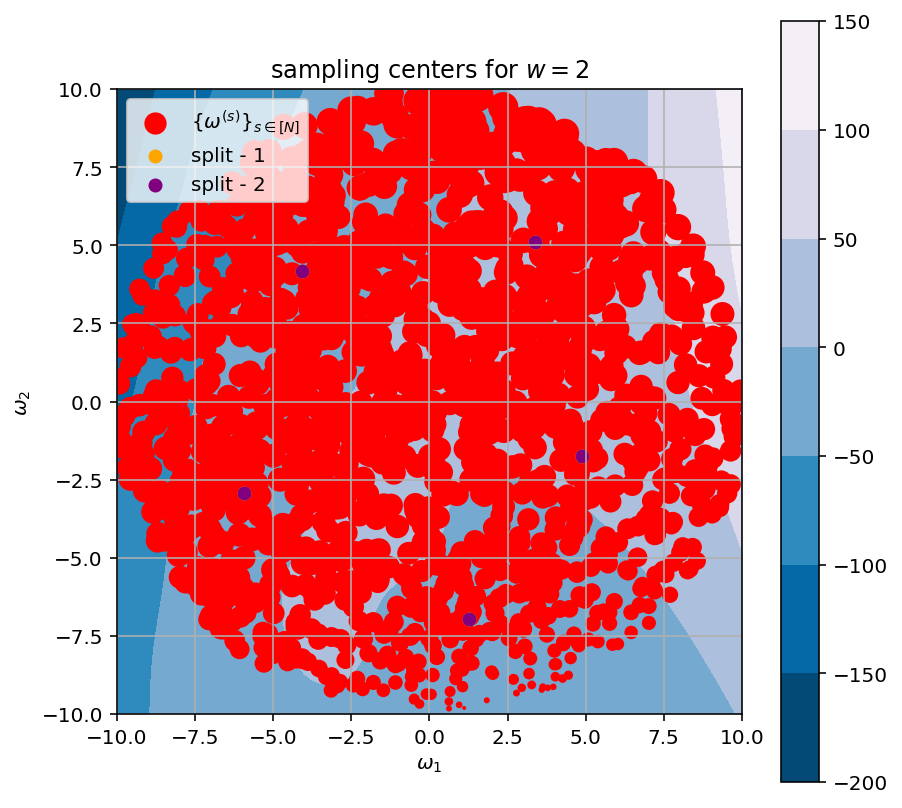

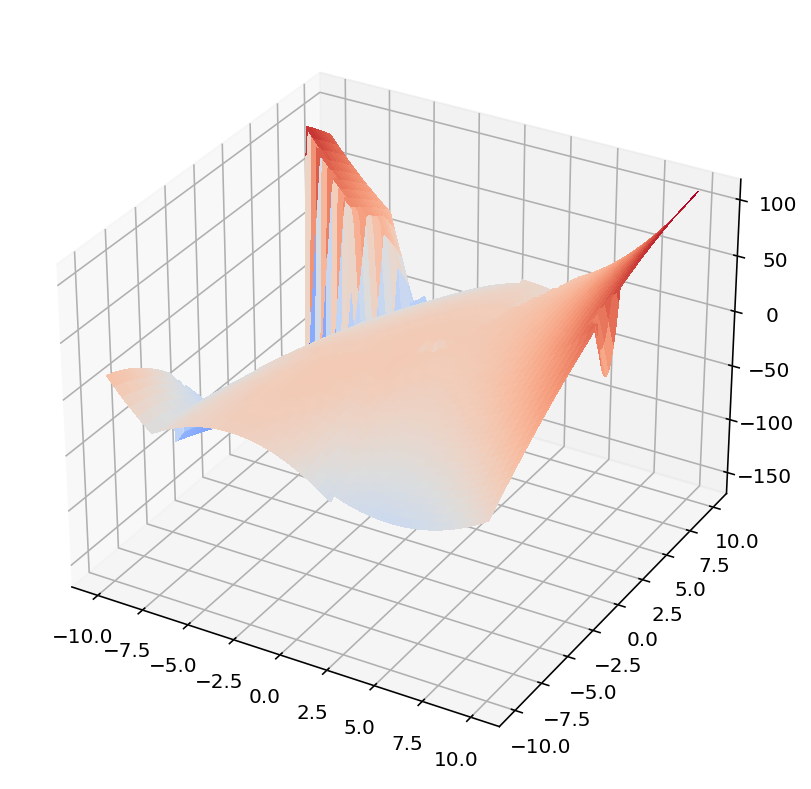

In [26]:
if w==2:
    
    from numpy import ma
    from matplotlib import cm, ticker
    

    tau_disp = gt(np.array(list_omegas)) 
    tau_pred = np.array([max(mat1_init@omega)-max(mat2_init@omega) for omega in polished_list_omegas])
    TAU = tau_disp.reshape((len(omega1),len(omega2)))
    TAU_pred = tau_pred.reshape((len(omega1),len(omega2)))
    
    plt.rcParams['figure.figsize'] = [7, 7]
    fig,ax = plt.subplots()
    plt.grid()
    plt.title('sampling centers for $w = $'+str(w))
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('$\\omega_1$')
    plt.ylabel('$\\omega_2$')
    cs = ax.contourf(OMEGA1, OMEGA2, TAU, cmap=cm.PuBu_r)
    plt.scatter(omegas[:,0],omegas[:,1],s=taus-np.min(taus)+1,color='red',label='$\{\\omega^{(s)}\}_{s\in[N]}$')
    centers1,centers2 = kmeans1.cluster_centers_,kmeans2.cluster_centers_
    plt.scatter(centers1[:,0],centers1[:,1],label='split - 1',color='orange')
    plt.scatter(centers2[:,0],centers2[:,1],label='split - 2',color='purple')
    cbar = fig.colorbar(cs)
    plt.legend()
    plt.show()
    
    from matplotlib.ticker import LinearLocator
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    plt.rcParams['figure.figsize'] = [7, 7]

    # Plot the surface.
    surf = ax.plot_surface(OMEGA1, OMEGA2, TAU_pred, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

    plt.show()

In [27]:
x_init = unfold(mat1_init,mat2_init)
print(' mat 1')
print(' ')
print(mat1_init)
print(' ')
print(' --- ')
print(' ')
print(' mat 2 ')
print(' ')
print(mat2_init)

 mat 1
 
[[ -82.16520365   85.47169148   12.7168812     9.64526515   -5.18931753
     0.64568844]
 [  62.83278125  -17.73745299  -35.2886697    16.45985251   -2.19597775
    -2.94552824]
 [ -74.35136295   69.73536688   15.04750022    6.81649289    0.80497915
     3.07202889]
 [ -79.22719492   93.54311249   14.37256187    9.31574114    1.81803875
   -18.69725425]
 [  89.50646054 -100.           -0.86983474  -23.19050204    6.20301146
    49.47586987]]
 
 --- 
 
 mat 2 
 
[[-79.88528502 100.          14.6134267    8.01067366   1.28658996
  -29.43553495]
 [ 89.27383579 -99.77901538  -0.64276041 -22.39969654   5.62364599
   44.9018365 ]
 [-81.87550474  90.16967051  12.92609077   8.52646598  -5.83417713
   -6.93469945]
 [-74.6105954   72.73104993  15.20324621   8.0740612    0.25430027
   -0.        ]
 [ 63.81155709  -7.70331753 -35.12648665  18.46166213  -2.69008366
   10.01520923]]


In [28]:
loss(x_init,target=taus,data=polished_omegas)

1.5637456251048791